In [117]:
import pyxdf
import numpy as np
import mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psychopy_experiments.brand_associations.brands_wordlist import WORDLIST
from pathlib import Path

In [118]:
instagram_wordlist = WORDLIST['instagram']
linkedin_wordlist = WORDLIST['linkedin']
unrelated_wordlist = WORDLIST['unrelated']
CATEGORY_MAP = {item: k for k, v in WORDLIST.items() for item in v}

In [119]:
import pandas as pd
import pyxdf

def load_multiple_subjects(csv_paths, xdf_paths):
    if len(csv_paths) != len(xdf_paths):
        raise ValueError("Number of CSV and XDF files must match!")

    subjects = [] 
    for i, (csv_path, xdf_path) in enumerate(zip(csv_paths, xdf_paths), start=1):
        subject_id = i

        csv_df = pd.read_csv(csv_path)
        csv_df["subject"] = subject_id

        streams, _ = pyxdf.load_xdf(xdf_path)

        subjects.append({
            "subject": subject_id,
            "csv": csv_df,
            "streams": streams,
            "csv_path": csv_path,
            "xdf_path": xdf_path
        })

    return subjects


In [ ]:
csv_paths = [
    'psychopy_experiments/brand_associations/brand_associations_levan.csv',
    'psychopy_experiments/brand_associations/brand_associations_raindi.csv',
    'psychopy_experiments/brand_associations/brand_associations_dato.csv'
]

xdf_paths = [
    'psychopy_experiments/brand_associations/brand_associations_levan.xdf',
    'psychopy_experiments/brand_associations/brand_associations_raindi.xdf',
    'psychopy_experiments/brand_associations/brand_associations_dato.xdf'
]

subjects = load_multiple_subjects(csv_paths, xdf_paths)

1) The EEG signal was re-referenced offline to a mastoid reference, then filtered using a 4th order
Butterworth filter with range 0.5–30 Hz and the initial 2048 Hz sampling rate downed to 256
Hz (including anti-aliasing). +

2) The EOG signal was used to remove eye artifacts following the
AAA method proposed in [50].  -

3) Trials with EEG amplitudes exceeding 70μV on any of the
channels were considered to be affected by muscle artifacts and were discarded +

4) as well as trials lacking button press responses (i.e., “no answer”). EEG epochs were extracted from -100 to
1000 ms to the onset of the stimulus, with the 100ms pre-stimulus period used for baseline correction. +



In [121]:
all_subjects = []

for subj_data in subjects:
    subject_id = subj_data["subject"]
    xdf_data = subj_data["streams"]
    csv_df = subj_data["csv"]

    markers = xdf_data[0]
    eeg = xdf_data[1]

    marker_time = markers["time_stamps"].copy()
    marker_data = np.array([x[0] for x in markers["time_series"]], dtype=int)


    TARGET_MARKER = 1
    keep_m = marker_data == TARGET_MARKER
    marker_time = marker_time[keep_m]
    marker_data = marker_data[keep_m]

    # time alignment
    time_offset = marker_time[0]
    marker_time = marker_time - time_offset

    eeg_time = eeg["time_stamps"].copy()
    CONST_OFFSET = 0.073
    eeg_time = eeg_time - time_offset - CONST_OFFSET

    eeg_data = eeg["time_series"][:, :8]


    info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
    raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
    raw.notch_filter(freqs=[50])
    raw.filter(0.5, 30, method="iir", iir_params=dict(order=4, ftype="butter"))


    samples = np.searchsorted(eeg_time, marker_time, side="left")
    samples = np.clip(samples, 0, len(eeg_time) - 1)

    # MNE events: [sample, 0, event_id]
    events = np.column_stack([samples, np.zeros(len(samples), dtype=int), marker_data]).astype(int)
    events = events[:-1]

    # epoching
    reject_criteria = dict(eeg=70e-6)  
    event_dict = dict(target=TARGET_MARKER)

    epochs = mne.Epochs(
        raw, events, event_id=event_dict,
        tmin=-0.1, tmax=1.0,
        baseline=(-0.1, 0.0),
        reject=reject_criteria,
        preload=True
    )

    all_subjects.append({
        "subject": subject_id,
        "raw": raw,
        "epochs": epochs,
        "events": events,
        "csv": csv_df
    })


Creating RawArray with float64 data, n_channels=8, n_times=113720
    Range : 0 ... 113719 =      0.000 ...   454.876 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -

5) Before applying the multivariate analysis methods, the signal was further downsampled to 80Hz to reduce dimensionality, as suggested in [43]. +

6) as well as trials lacking button press responses where discarded (i.e., “no answer”) +

In [122]:
for subj in all_subjects:
    epochs = subj["epochs"]
    events = subj["events"]
    csv_data = subj["csv"]

    # 1) Align to what survived rejection (epochs.selection refers to ORIGINAL events/csv)
    good_idx = epochs.selection
    csv_kept = csv_data.iloc[good_idx].reset_index(drop=True)
    csv_kept['category'] = csv_kept['target'].map(CATEGORY_MAP)
    events_kept = events[good_idx]


    has_response = csv_kept["resp_key"].notna().to_numpy()

    epochs_resp = epochs[has_response]
    events_resp = events_kept[has_response]
    csv_resp = csv_kept.loc[has_response].reset_index(drop=True)

    epochs_bf = epochs_resp.copy().resample(80, npad="auto")

    subj["epochs"] = epochs_resp
    subj["epochs_bf"] = epochs_bf
    subj["events"] = events_resp
    subj["csv"] = csv_resp


დამკვეთთან და ისეც გამოსატანია : 

1) მონაწილეთა რაოდენობა 
2) trials with “no answer”
3) EEG amplitude exceeding 70μV epochs
4) trials remained: per brand and category 
5)

Proposed single word calculation: N400 extraction. 

For each trial, we applied our
recently developed spatiotemporal extension of the linearly constrained minimum variance
beamformer (stLCMV) [43], which relies on the targeted ERP component’s temporal and spatial response profiles, further called templates. In contrast with [43], where 2 predefined categories were required (related and unrelated), in the current study, we constructed these
templates using only the Unrelated category trials of all subjects, for both companies, so as not
to make any prior assumptions about relatedness of the trials. The Unrelated trials were then
removed from further N400 analysis. Subjects with less than 30 useful trials were excluded. For
the remaining subjects, the N400 was extracted from single trials by applying the aforementioned stLCMV beamformer and its (scalar) output taken as N400 response strength. In addition, as recently proposed by Van Petten [55], for each subject individually, we converted the
N400 responses into z-scores to overcome the variability in EEG amplitudes among subjects.

In [123]:
def make_temporal_window(times, tmin=0.30, tmax=0.45, kind="hann"):

    mask = (times >= tmin) & (times <= tmax)
    if not mask.any():
        raise ValueError("No time points inside the requested N400 window.")

    w = np.zeros_like(times, dtype=float)

    if kind == "hann":
        w[mask] = np.hanning(mask.sum())
    elif kind == "rect":
        w[mask] = 1.0
    else:
        raise ValueError("kind must be 'hann' or 'rect'")

    return w, mask


In [124]:
def build_n400_template_from_unrelated(
    epochs,
    unrelated_idx,
    tmin=0.30,
    tmax=0.45,
    window_kind="hann"
):
    """
    Build a GLOBAL spatio-temporal N400 template from unrelated trials.

    Parameters
    ----------
    epochs : mne.Epochs
        Epochs containing ONLY unrelated trials (or pooled unrelated trials)
    unrelated_idx : array-like
        Indices of unrelated trials inside epochs
    tmin, tmax : float
        N400 time window in seconds
    window_kind : {"hann", "rect"}
        Temporal weighting

    Returns
    -------
    s : ndarray, shape (n_channels * n_times,)
        Flattened spatio-temporal N400 template
    """

    # Epoch data: (n_trials, n_channels, n_times)
    X = epochs.get_data()
    times = epochs.times

    n_ch = X.shape[1]
    n_t = X.shape[2]

    # Temporal window
    w_t, _ = make_temporal_window(times, tmin=tmin, tmax=tmax, kind=window_kind)

    # Average ERP over unrelated trials
    erp_unrel = X[unrelated_idx].mean(axis=0)   # (n_ch, n_times)

    # Apply temporal weighting
    erp_weighted = erp_unrel * w_t[np.newaxis, :]

    # Flatten to spatio-temporal vector
    s = erp_weighted.reshape(n_ch * n_t)

    # Normalize (important for numerical stability)
    norm = np.linalg.norm(s)
    if norm > 0:
        s = s / norm

    return s


In [125]:
unrel_epochs_list = []
for subj in all_subjects:   # <-- use the list you updated
    epochs_bf = subj["epochs_bf"]
    csv = subj["csv"]
    unrel_mask = csv["target"].isin(unrelated_wordlist).to_numpy()
    unrel_epochs_list.append(epochs_bf[unrel_mask])

epochs_unrel_all = mne.concatenate_epochs(unrel_epochs_list)


# build global template s (spatio-temporal)
template_s = build_n400_template_from_unrelated(
    epochs_unrel_all,
    unrelated_idx=np.arange(len(epochs_unrel_all)),
    tmin=0.30, tmax=0.45,           # paper-aligned N400 emphasis
    window_kind="hann"
)


Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


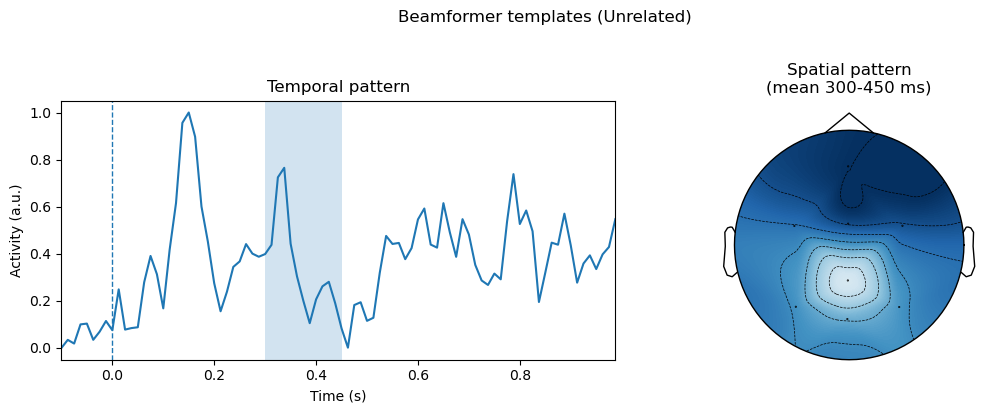

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import mne

def plot_beamformer_templates_from_unrelated(
    epochs_unrel,
    tmin_peak=0.30, tmax_peak=0.45,
    montage_name="standard_1020",
    temporal_mode="gfp",   # "gfp" or "mean"
    title_prefix="Template"
):
    """
    Reproduce paper-like Fig 4:
      - Temporal pattern: time course of activity (GFP-like or mean across channels)
      - Spatial pattern: topomap averaged over [tmin_peak, tmax_peak]

    epochs_unrel: mne.Epochs containing ONLY Unrelated trials (already preprocessed)
    """

    # --- Ensure montage / channel positions (needed for topomap) ---
    epochs_m = epochs_unrel.copy()
    montage = mne.channels.make_standard_montage(montage_name)

    # IMPORTANT: If you have missing channels (e.g., only 8), don't "raise"
    epochs_m.set_montage(montage, on_missing="ignore")

    # --- Compute ERP (average of unrelated trials) ---
    X = epochs_m.get_data()               # (n_trials, n_ch, n_times)
    times = epochs_m.times
    erp = X.mean(axis=0)                  # (n_ch, n_times)

    # --- Temporal pattern ---
    if temporal_mode == "gfp":
        # GFP-like magnitude across channels at each time (good for "template activity")
        temporal = np.sqrt((erp ** 2).mean(axis=0))
    elif temporal_mode == "mean":
        # Simple mean over channels (can cancel if polarities differ)
        temporal = erp.mean(axis=0)
    else:
        raise ValueError("temporal_mode must be 'gfp' or 'mean'")

    # Normalize for visualization (paper shows arbitrary units)
    temporal = (temporal - temporal.min()) / (temporal.max() - temporal.min() + 1e-12)

    # --- Spatial pattern (average over N400 window) ---
    mask = (times >= tmin_peak) & (times <= tmax_peak)
    if not mask.any():
        raise ValueError("No samples in the requested [tmin_peak, tmax_peak] window.")
    spatial = erp[:, mask].mean(axis=1)   # (n_ch,)

    # Put spatial vector in an Evoked for plotting
    info = epochs_m.copy().pick_types(eeg=True).info
    evoked_spatial = mne.EvokedArray(spatial[:, None], info, tmin=0.0)

    # --- Plot side-by-side like the paper ---
    fig, axes = plt.subplots(1, 2, figsize=(11, 4), gridspec_kw={"width_ratios":[1.2, 1]})

    # Temporal plot
    ax = axes[0]
    ax.plot(times, temporal)
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_title("Temporal pattern")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Activity (a.u.)")
    ax.set_xlim(times[0], times[-1])

    ax.axvspan(tmin_peak, tmax_peak, alpha=0.2)

  
    mne.viz.plot_topomap(
        evoked_spatial.data[:, 0],
        evoked_spatial.info,
        axes=axes[1],
        show=False,
        contours=6
    )
    axes[1].set_title("Spatial pattern\n(mean {:.0f}-{:.0f} ms)".format(tmin_peak*1000, tmax_peak*1000))

    fig.suptitle(title_prefix, y=1.02)
    plt.tight_layout()
    plt.show()

    return temporal, spatial

temporal, spatial = plot_beamformer_templates_from_unrelated(
    epochs_unrel_all,
    tmin_peak=0.3, tmax_peak=0.45,   
    temporal_mode="gfp",
    title_prefix="Beamformer templates (Unrelated)")



გამოსატანია : 
1) რამდენი trial გამოვიყენეთ unrelated category დან beamformer temaplate დასათვლელად. (In accordance
with the N400 literature, these templates reveal a maximal activation over centro-parietal electrodes (cf., spatial template in Fig 4), and a clear peak around 400 ms (cf., temporal template) ) ჩვენ გვაქვს მარტო 8 channel და re-referenced to mastoids ვერ ვშვებით

In [127]:
from sklearn.covariance import LedoitWolf

def st_lcmv_scores(epochs, template_s, cov_shrinkage=True, eps=1e-8):
    """
    Spatio-temporal LCMV / matched-filter score:
        w = R^{-1} s / (s^T R^{-1} s)
        score_i = x_i^T w

    epochs: mne.Epochs
    template_s: (n_features,) where n_features = n_channels * n_times

    Returns:
        scores: (n_trials,) single scalar per epoch
    """
    X = epochs.get_data().reshape(len(epochs), -1)  # (n_trials, n_features)

    # Covariance of features across trials (robust shrinkage recommended)
    if cov_shrinkage:
        R = LedoitWolf().fit(X).covariance_
    else:
        R = np.cov(X, rowvar=False)

    # Regularize for stability
    R = R + eps * np.eye(R.shape[0])

    s = template_s.reshape(-1, 1)             # (n_features, 1)
    Rinv_s = np.linalg.solve(R, s)            # (n_features, 1)
    denom = float(s.T @ Rinv_s)               # scalar

    if np.isclose(denom, 0.0):
        raise ValueError("Template leads to near-zero denominator; check template/covariance.")

    w = (Rinv_s / denom).reshape(-1)          # (n_features,)
    scores = X @ w                             # (n_trials,)
    return scores


In [128]:
MIN_USEFUL = 30  # paper threshold (subjects with <30 useful trials excluded)

kept_subjects = []
dropped_subjects = []

for subj in all_subjects:   # or `subjects` if that is your list
    sid = subj["subject"]
    epochs_bf = subj["epochs_bf"]
    csv = subj["csv"].copy()

    # masks in current (already aligned) index space
    is_unrel = csv["target"].isin(unrelated_wordlist).to_numpy()
    keep_mask = ~is_unrel

    n_useful = int(keep_mask.sum())
    subj["n_useful"] = n_useful

    if n_useful < MIN_USEFUL:
        dropped_subjects.append((sid, n_useful))
        continue

    # Remove Unrelated trials from further N400 analysis (paper step)
    epochs_rel = epochs_bf[keep_mask]
    csv_rel = csv.loc[keep_mask].reset_index(drop=True)

    # stLCMV single-trial N400 strength
    n400_raw = st_lcmv_scores(epochs_rel, template_s, cov_shrinkage=True)

    # Optional sign fix: ensure incongruent is more negative than congruent (N400 effect direction)
    # cong = (csv_rel["congruency"] == "congruent").to_numpy()
    # incong = (csv_rel["congruency"] == "incongruent").to_numpy()
    # if cong.any() and incong.any():
    #     if n400_raw[incong].mean() > n400_raw[cong].mean():
    #         n400_raw *= -1.0

    # Per-subject z-score (Van Petten)
    n400_z = (n400_raw - n400_raw.mean()) / (n400_raw.std(ddof=0) + 1e-12)

    # Attach to CSV
    csv_rel["n400_raw"] = n400_raw
    csv_rel["n400_z"] = n400_z
    csv_rel["subject"] = sid

    # Save back
    subj["epochs_rel_bf"] = epochs_rel
    subj["csv_n400"] = csv_rel

    kept_subjects.append(subj)

print("Dropped subjects (<30 useful trials):", dropped_subjects)
print("Kept subjects:", [s["subject"] for s in kept_subjects])


C:\Users\Gamge\AppData\Local\Temp\ipykernel_8292\2256792950.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)               # scalar
C:\Users\Gamge\AppData\Local\Temp\ipykernel_8292\2256792950.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)               # scalar


Dropped subjects (<30 useful trials): []
Kept subjects: [1, 2, 3]


C:\Users\Gamge\AppData\Local\Temp\ipykernel_8292\2256792950.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(s.T @ Rinv_s)               # scalar


In [129]:
all_df = pd.concat(
    [subj["csv_n400"] for subj in kept_subjects],
    ignore_index=True
)



In [130]:
word_subj = (
    all_df.groupby(["subject", "brand", "target"], as_index=False)
          .agg(
              n400_word=("n400_z", "mean"),
              n_rep=("n400_z", "size"),
              rt_mean=("rt_ms_from_target", "mean") if "rt_ms_from_target" in all_df.columns else ("n400_z","size")
          )
)




In [131]:
word_group = (
    word_subj.groupby(["brand", "target"], as_index=False)
             .agg(
                 n400_expected=("n400_word", "mean"),
                 n_sub=("n400_word", "count"),
                 n_rep_total=("n_rep", "sum")
             )
)


In [132]:
word_group.sort_values(["brand", "n400_expected"], ascending=[True, False])


,brand,target,n400_expected,n_sub,n_rep_total
17,instagram,სივი,1.246918,3,4
9,instagram,ნეთვორქინგი,0.906790,2,2
14,instagram,სამსახური,0.782469,3,4
12,instagram,რეკრუტერი,0.701110,3,5
6,instagram,ლაიქი,0.266875,1,2
15,instagram,სელფი,0.207767,3,6
10,instagram,პოსტები,0.185109,2,3
18,instagram,ფოტოები,0.130254,2,3
2,instagram,ვიდეოები,0.090635,2,3
5,instagram,კონტაქტი,0.073124,3,4


In [133]:

pivoted = (
    word_group
    .pivot(index="target", columns="brand", values="n400_expected")  
    .rename_axis("Word")
    .rename(columns={"instagram": "Instagram", "linkedin": "LinkedIn"})
)

df_pivot = pd.DataFrame(pivoted.round(2))
df_pivot

brand,Instagram,LinkedIn
Word,,
ეიჩარი,-0.51,-0.65
ვაკანსია,-0.06,-0.02
ვიდეოები,0.09,-0.70
ინფლუენსერი,-0.47,0.66
კარიერა,-0.43,0.08
კონტაქტი,0.07,-0.25
ლაიქი,0.27,-0.14
ლურჯი,-1.06,0.74
მეგობრები,-0.49,-0.15


In [134]:

from sklearn.preprocessing import StandardScaler

df_words = word_group.copy()

brands = sorted(df_words["brand"].unique())


Proposed brand analysis: Single-brand analysis. 

Albeit we initially collected target
words belonging to 3 categories, we did not assume the existence of those categories in our
N400 analysis: instead of considering pre-defined categories, we aimed to identify “natural”
ones by adopting a data-driven clustering analysis of N400 responses. In this way, the found
clusters represent natural categories of words according to their N400 responses with the most
negative N400 ones representing the most unrelated (non-associated) words and vice-versa.
We adopted an automatic approach to determine the optimal number of clusters (for the full
procedure see S1 Appendix)

In [135]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def auto_kmeans_1d(values, k_min=2, k_max=4, random_state=42):
    """
    values: 1D numpy array of n400_expected
    """
    X = values.reshape(-1, 1)
    X = StandardScaler().fit_transform(X)

    best_k = None
    best_labels = None
    best_score = -np.inf

    max_k = min(k_max, len(values) - 1)
    for k in range(k_min, max_k + 1):
        km = KMeans(n_clusters=k, n_init=50, random_state=random_state)
        labels = km.fit_predict(X)

        score = silhouette_score(X, labels)
        if score > best_score:
            best_k = k
            best_score = score
            best_labels = labels

    return best_k, best_labels, best_score


In [136]:
clustered_words = []
cluster_summary = {}

for brand in brands:
    dfb = df_words[df_words["brand"] == brand].copy()
    dfb = dfb.sort_values("target").reset_index(drop=True)

    values = dfb["n400_expected"].to_numpy()

    best_k, labels, sil = auto_kmeans_1d(values)

    dfb["cluster"] = labels

    # Order clusters by mean N400 (most negative = most unrelated)
    cluster_means = (
        dfb.groupby("cluster")["n400_expected"]
        .mean()
        .sort_values()
    )

    # Re-label clusters by semantic rank
    cluster_rank_map = {old: rank for rank, old in enumerate(cluster_means.index)}
    dfb["cluster_ranked"] = dfb["cluster"].map(cluster_rank_map)

    clustered_words.append(dfb)

    cluster_summary[brand] = {
        "best_k": best_k,
        "silhouette": sil,
        "cluster_means": cluster_means
    }


c:\Users\Gamge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Gamge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Gamge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Gamge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [137]:
word_clustered = pd.concat(clustered_words, ignore_index=True)
word_clustered.head()


,brand,target,n400_expected,n_sub,n_rep_total,cluster,cluster_ranked
0,instagram,ეიჩარი,-0.511148,3,5,2,1
1,instagram,ვაკანსია,-0.059210,3,5,1,2
2,instagram,ვიდეოები,0.090635,2,3,1,2
3,instagram,ინფლუენსერი,-0.465650,2,3,2,1
4,instagram,კარიერა,-0.429936,3,5,2,1


In [138]:
for brand in brands:
    print(f"\nBrand: {brand}")
    print("Optimal k:", cluster_summary[brand]["best_k"])
    print(cluster_summary[brand]["cluster_means"])



Brand: instagram
Optimal k: 4
cluster
0   -1.005636
2   -0.438455
1    0.098648
3    0.909322
Name: n400_expected, dtype: float64

Brand: linkedin
Optimal k: 2
cluster
1   -0.245161
0    0.623659
Name: n400_expected, dtype: float64


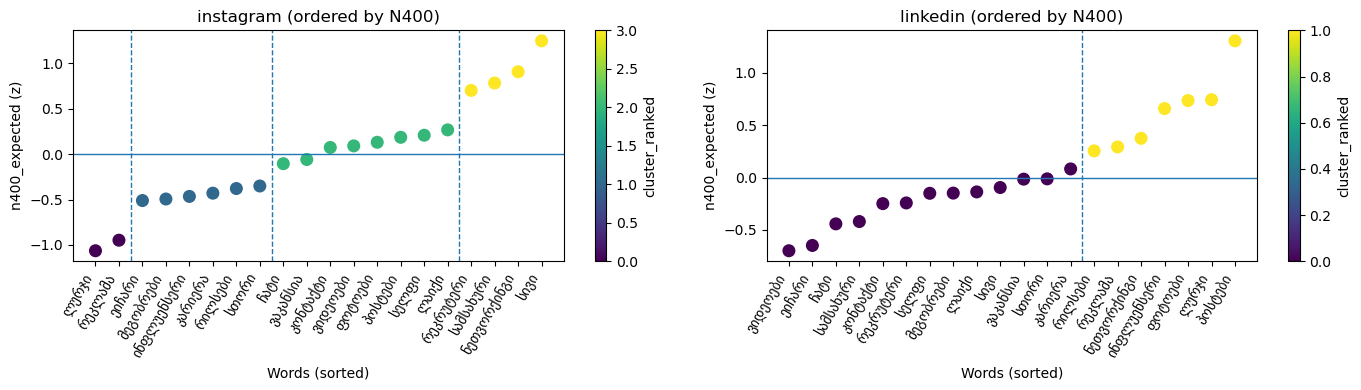

In [139]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_words_sorted(word_clustered, brands=None,
                                brand_col="brand", value_col="n400_expected",
                                cluster_col="cluster_ranked", word_col=None):
    if word_col is None:
        word_col = "target_latin" if "target_latin" in word_clustered.columns else "target"
    if brands is None:
        brands = sorted(word_clustered[brand_col].unique())

    fig, axes = plt.subplots(1, len(brands), figsize=(7*len(brands), 4), sharey=False)
    if len(brands) == 1:
        axes = [axes]

    for ax, b in zip(axes, brands):
        d = word_clustered[word_clustered[brand_col] == b].copy()
        d = d.sort_values(value_col).reset_index(drop=True)

        x = np.arange(len(d))
        sc = ax.scatter(x, d[value_col], c=d[cluster_col], s=70)  # default colormap

        ax.axhline(0, linewidth=1)
        ax.set_title(f"{b} (ordered by N400)")
        ax.set_xlabel("Words (sorted)")
        ax.set_ylabel("n400_expected (z)")

        ax.set_xticks(x)
        ax.set_xticklabels(d[word_col], rotation=60, ha="right")

        # Optional: show cluster boundaries (where cluster changes)
        changes = np.where(np.diff(d[cluster_col].to_numpy()) != 0)[0]
        for idx in changes:
            ax.axvline(idx + 0.5, linestyle="--", linewidth=1)

        plt.colorbar(sc, ax=ax, label="cluster_ranked")

    plt.tight_layout()
    plt.show()

plot_clustered_words_sorted(word_clustered)


Proposed brand analysis: Multi-brand analysis. 

A further step in our multi-brand analysis is the intersection of the clusters found in the Single-brand analysis with the aim to list the
target words that are associated with both brands (associations in common) or not (distinctive
associations).

In [140]:

df = word_clustered[["brand", "target", "cluster_ranked"]].copy()


cluster_pivot = (
    df.pivot(index="target", columns="brand", values="cluster_ranked")
    .dropna()  
)

cluster_pivot["cluster_diff"] = (
    cluster_pivot["instagram"] - cluster_pivot["linkedin"]
).abs()

def label_association(diff):
    if diff <= 1:
        return "common"
    else:
        return "distinctive"

cluster_pivot["association_type"] = cluster_pivot["cluster_diff"].apply(label_association)
multi_brand = (
    cluster_pivot
    .reset_index()
    .sort_values("cluster_diff", ascending=False)
)

multi_brand



brand,target,instagram,linkedin,cluster_diff,association_type
12,რეკრუტერი,3,0,3,distinctive
17,სივი,3,0,3,distinctive
14,სამსახური,3,0,3,distinctive
19,ჩატი,2,0,2,distinctive
2,ვიდეოები,2,0,2,distinctive
5,კონტაქტი,2,0,2,distinctive
6,ლაიქი,2,0,2,distinctive
15,სელფი,2,0,2,distinctive
9,ნეთვორქინგი,3,1,2,distinctive
1,ვაკანსია,2,0,2,distinctive
